# Time Series Forecasting

Author: Charles Liu

This notebook demonstrate my RNN models for stock price forecasting. It includes the data preprocessing, model creation, training, testing and visualizations

This forecasting model is treated in two ways:
  1. Regression: predict the close price of the next day, where the price is numeric. See Part I.
  2. Classification: predict the future close return is positive or negative. See Part II.
  
Note: Please make sure the environment has been setup
```bash
cd path/to/stock_forecasting/
source set_env.sh
```

## Part I. Close Price Forecasting

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

TICKER = 'ANZ'
MISSING_VALUE_STRAGETY = 'mean'
SAVE_MODEL = False

## 1. Prepare data

### Select a ticker and read the data to data frame

In [2]:
# Read dataframe. Here only a dates with valid data of the selected ticker is read
from pricedata import read_stock_data, read_dates
df_raw = read_stock_data(TICKER)

print("Raw data shape:",  df_raw.shape)
df_raw.head()

Raw data shape: (882, 5)


,open,high,low,close,volume
date,,,,,
2015-01-02,32.09,32.29,31.91,32.23,1925826
2015-01-05,32.21,32.41,32.00,32.17,2507257
2015-01-06,31.84,32.01,31.59,31.78,4771084
2015-01-07,31.78,31.91,31.46,31.72,4039936
2015-01-08,31.92,32.09,31.70,31.91,3043671


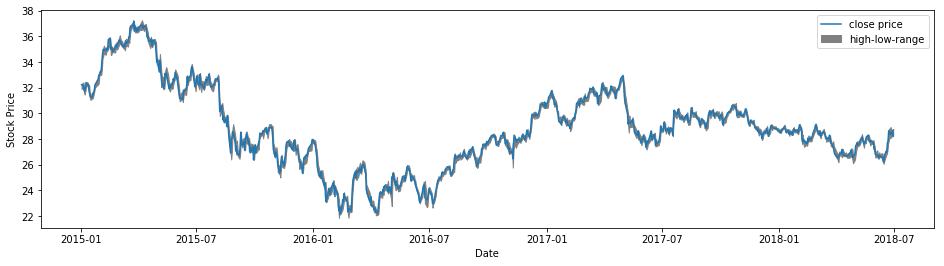

In [3]:
# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
df = df_raw
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Handling missing values.

A number of missing value handling methods are implemented 

In [4]:
dates = read_dates()
if len(dates) > len(df_raw):
    
    # Create a data frame will dates of full range
    df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
    df_full.loc[df_raw.index] = df_raw.astype(float)
    
    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]
    if df_full.isna().sum().sum() > 0.2 * df_full.size:
        raise ValueError('Too many NaNs: {}%'.format(100 * df_full.isna().sum().sum() / df_full.size))
        
    if MISSING_VALUE_STRAGETY == 'discard':
        df_full = df_raw
        
    elif MISSING_VALUE_STRAGETY == '0':
        df_full = df_full.fillna(0)
        
    elif MISSING_VALUE_STRAGETY == 'mean':
        from sklearn.preprocessing import Imputer
        imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
        imputer.fit(df_raw.values)
        X = imputer.transform(df_full.values)
        df_full = pd.DataFrame(X, index=df_full.index, columns=df_full.columns)
        
    elif MISSING_VALUE_STRAGETY == 'interpolate':
        df_full = df_full.interpolate(method='linear')
        
    else:
        pass
    
else:
    df_full = df_raw
    
print("Full data shape:",  df_full.shape)

df_full.head()

Full data shape: (883, 5)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,open,high,low,close,volume
2015-01-02,32.09,32.29,31.91,32.23,1925826.0
2015-01-05,32.21,32.41,32.00,32.17,2507257.0
2015-01-06,31.84,32.01,31.59,31.78,4771084.0
2015-01-07,31.78,31.91,31.46,31.72,4039936.0
2015-01-08,31.92,32.09,31.70,31.91,3043671.0


### Scaling

The MinMax scaling is used to normalize data in each column.

In [5]:
from sklearn.preprocessing import MinMaxScaler as Scaler
scaler = Scaler(feature_range = (0, 1))
X = scaler.fit_transform(df_full.values)
df_scaled = pd.DataFrame(index=df_full.index, data=X, columns=df_full.columns)
df_scaled.head()

,open,high,low,close,volume
2015-01-02,0.665993,0.664638,0.674497,0.669554,0.000249
2015-01-05,0.674074,0.672752,0.680537,0.665556,0.019358
2015-01-06,0.649158,0.645707,0.653020,0.639574,0.093760
2015-01-07,0.645118,0.638945,0.644295,0.635576,0.069730
2015-01-08,0.654545,0.651116,0.660403,0.648235,0.036988


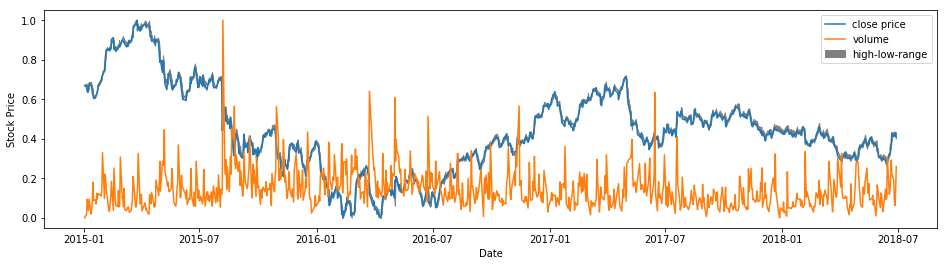

In [6]:
# Visualize the scaled data. 
df = df_scaled
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.plot(df.index, df['volume'], label='volume')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Prepare the training, validation and test data

Here are some feature parameters:
   1. Input features: The Open, high, low and high prices and the trading volume are used.
   2. Look back time: 5 days, i.e. totally 25 features will be used.
   3. Target feature: the close price of the next day

In [7]:
lookback = 5
features = 5
delay = 1
total_samples = len(df_full) - lookback - delay + 1
training_samples = int(total_samples * 0.6)
validation_samples = int(total_samples * 0.2)
test_samples = total_samples - training_samples - validation_samples

print("Total samples:", total_samples)
print("Training:", training_samples)
print("Validation:", validation_samples)
print("Test:", test_samples)

Total samples: 878
Training: 526
Validation: 175
Test: 177


In [8]:
from helpers import sample_generator, vectorize_input, vectorize_target

sample_generator = sample_generator(df_scaled, lookback=lookback, delay=delay, target_col=3)
sample_data = list(sample_generator)

# np.random.shuffle(sample_data)

X_data = vectorize_input(sample_data)
y_data = vectorize_target(sample_data)

X_train = X_data[:training_samples]
y_train = y_data[:training_samples]

X_valid = X_data[training_samples: training_samples + validation_samples]
y_valid = y_data[training_samples: training_samples + validation_samples]

X_test = X_data[training_samples + validation_samples: ]
y_test = y_data[training_samples + validation_samples: ]


X_train = X_train.reshape(X_train.shape[0], 1, lookback * features)
X_valid = X_valid.reshape(X_valid.shape[0], 1, lookback * features)
X_test = X_test.reshape(X_test.shape[0], 1, lookback * features)

X_train.shape

(526, 1, 25)

### A forecasting model using recurrent neural networks

In [9]:
from keras.models import Sequential
from keras import layers

units = 64

model = Sequential()

model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(rate=0.2))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.2))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.2))

model.add(layers.LSTM(units=units))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(units=units, activation='relu'))

model.add(layers.Dense(units=1))

print(model.summary())

model.compile(optimizer='adam', loss='mean_absolute_error')

regression_history = model.fit(X_train, y_train, epochs=100, batch_size = lookback * features, validation_data=(X_valid, y_valid))


if SAVE_MODEL:
    model.save(os.path.join('models', 'regression', TICKER + '.h5'))

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 64)             23040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
________________________________________________

526/526 [==============================] - 0s 837us/step - loss: 0.0362 - val_loss: 0.0293
Epoch 59/100
526/526 [==============================] - 0s 813us/step - loss: 0.0366 - val_loss: 0.0358
Epoch 60/100
526/526 [==============================] - 0s 805us/step - loss: 0.0376 - val_loss: 0.0210
Epoch 61/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0370 - val_loss: 0.0244
Epoch 62/100
526/526 [==============================] - 0s 846us/step - loss: 0.0354 - val_loss: 0.0377
Epoch 63/100
526/526 [==============================] - 0s 863us/step - loss: 0.0375 - val_loss: 0.0212
Epoch 64/100
526/526 [==============================] - 0s 805us/step - loss: 0.0381 - val_loss: 0.0249
Epoch 65/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0367 - val_loss: 0.0201
Epoch 66/100
526/526 [==============================] - 0s 785us/step - loss: 0.0355 - val_loss: 0.0240
Epoch 67/100
526/526 [==============================] - 0s 846us/step - loss: 0.0

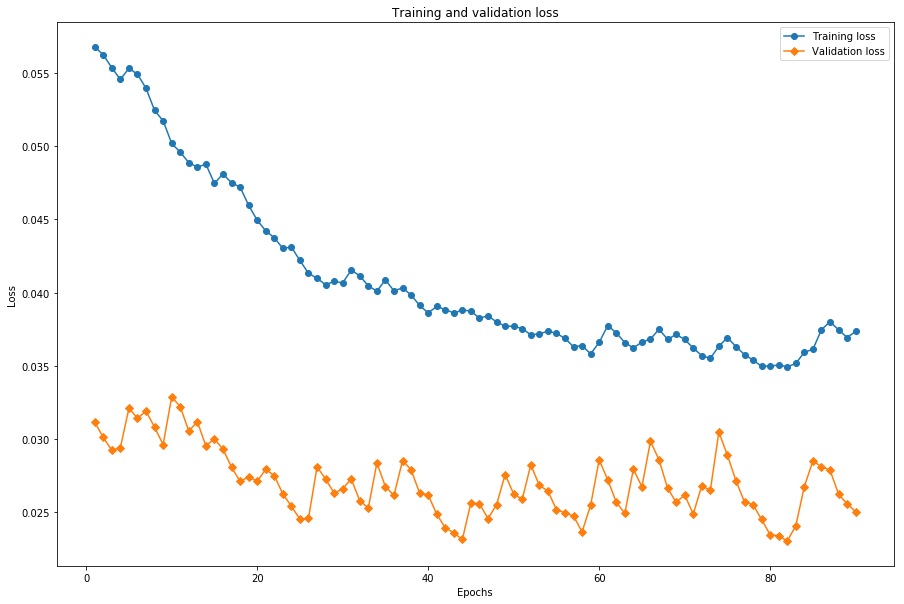

In [10]:
from helpers import smooth_curve

## Validation of model fitting
fig = plt.figure(figsize=(15, 10))
history_dict = regression_history.history
loss_values = history_dict['loss'][10:]
val_loss_values = history_dict['val_loss'][10:]

# Smooth the curve and only show data after the 10th point
loss_values = smooth_curve(loss_values)
val_loss_values = smooth_curve(val_loss_values)

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'o-', label='Training loss')
plt.plot(epochs, val_loss_values, 'D-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig('document/figures/regression_epochs.pdf')

regession error baseline:  0.012287263036763363
Mean absolute error:  0.25222480517570967


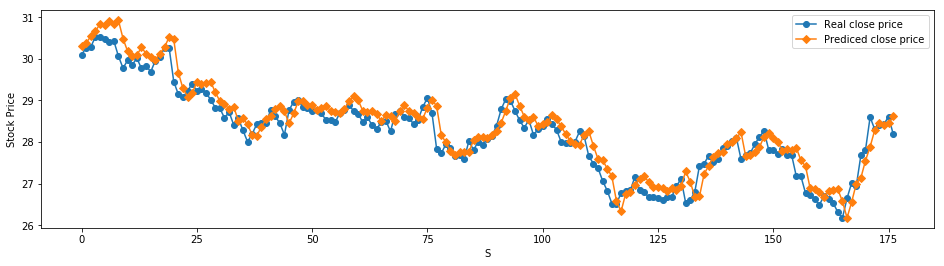

In [11]:
# The baseline error
baseline_regression_error = np.mean(np.abs(y_test[1:] - y_test[:-1]))
print("regession error baseline: ", baseline_regression_error)

# Predict the model
y_test_real = y_test
y_test_pred = model.predict(X_test).reshape(-1,)

# Inverse the scale
y_test_real = scaler.inverse_transform(np.array([y_test_real] * 5).transpose())[:,0]
y_test_pred = scaler.inverse_transform(np.array([y_test_pred] * 5).transpose())[:,0]

regression_error = np.mean(np.abs(y_test_real - y_test_pred))
print("Mean absolute error: ", regression_error)


# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
fig = plt.figure(figsize=(16, 4))
plt.plot(y_test_real, "o-", label='Real close price')
#plt.plot(range(1, len(y_test_real) + 1), y_test_real, "s-", label='Real close price')
plt.plot(y_test_pred, "D-", label='Prediced close price')
plt.xlabel("S")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()
#fig.savefig('document/figures/regression_test.pdf')

## Part II:  Binary classification of future close return

Binary categories: 1 if the future close return is positive or 0 other else.

In [12]:
from keras.utils import to_categorical

def future_close_return(X, y):
    fcr =  y / X[:, 0, -2] - 1
    return fcr 
    
    
train_labels = future_close_return(X_train, y_train) > 0
valid_labels = future_close_return(X_valid, y_valid) > 0
test_labels = future_close_return(X_test, y_test) > 0

units = 64

classifier = Sequential()

classifier.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
classifier.add(layers.Dropout(rate=0.2))

classifier.add(layers.LSTM(units=units))
classifier.add(layers.Dropout(rate=0.2))

# classifier.add(layers.Dense(units, activation='relu'))

classifier.add(layers.Dense(1, activation='sigmoid'))
    
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
classification_history = classifier.fit(X_train, train_labels, epochs=100, batch_size=lookback * features,
                                        validation_data=(X_valid, valid_labels))

if SAVE_MODEL:
    model.save(os.path.join('models', 'classification', TICKER + '.h5'))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


Train on 526 samples, validate on 175 samples
Epoch 1/100
526/526 [==============================] - 3s 6ms/step - loss: 0.6933 - acc: 0.5133 - val_loss: 0.6932 - val_acc: 0.5029
Epoch 2/100
526/526 [==============================] - 0s 475us/step - loss: 0.6925 - acc: 0.5247 - val_loss: 0.6938 - val_acc: 0.5029
Epoch 3/100
526/526 [==============================] - 0s 482us/step - loss: 0.6928 - acc: 0.5247 - val_loss: 0.6949 - val_acc: 0.5029
Epoch 4/100
526/526 [==============================] - 0s 478us/step - loss: 0.6926 - acc: 0.5247 - val_loss: 0.6938 - val_acc: 0.5029
Epoch 5/100
526/526 [==============================] - 0s 516us/step - loss: 0.6933 - acc: 0.5247 - val_loss: 0.6948 - val_acc: 0.5029
Epoch 6/100
526/526 [==============================] - 0s 841us/step - loss: 0.6927 - acc: 0.5247 - val_loss: 0.6945 - val_acc: 0.5029
Epoch 7/100
526/526 [==============================] - 0s 482us/step - loss: 0.6923 - acc: 0.5247 - val_loss: 0.6938 - val_acc: 0.5029
Epoch 8/100

Epoch 61/100
526/526 [==============================] - 0s 519us/step - loss: 0.6961 - acc: 0.5247 - val_loss: 0.6957 - val_acc: 0.5029
Epoch 62/100
526/526 [==============================] - 0s 869us/step - loss: 0.6903 - acc: 0.5285 - val_loss: 0.6924 - val_acc: 0.5143
Epoch 63/100
526/526 [==============================] - 0s 487us/step - loss: 0.6899 - acc: 0.5380 - val_loss: 0.6933 - val_acc: 0.5086
Epoch 64/100
526/526 [==============================] - 0s 506us/step - loss: 0.6919 - acc: 0.5266 - val_loss: 0.6956 - val_acc: 0.5029
Epoch 65/100
526/526 [==============================] - 0s 523us/step - loss: 0.6894 - acc: 0.5247 - val_loss: 0.6923 - val_acc: 0.5143
Epoch 66/100
526/526 [==============================] - 0s 526us/step - loss: 0.6896 - acc: 0.5304 - val_loss: 0.6925 - val_acc: 0.5257
Epoch 67/100
526/526 [==============================] - 0s 512us/step - loss: 0.6891 - acc: 0.5342 - val_loss: 0.6925 - val_acc: 0.5200
Epoch 68/100
526/526 [==========================

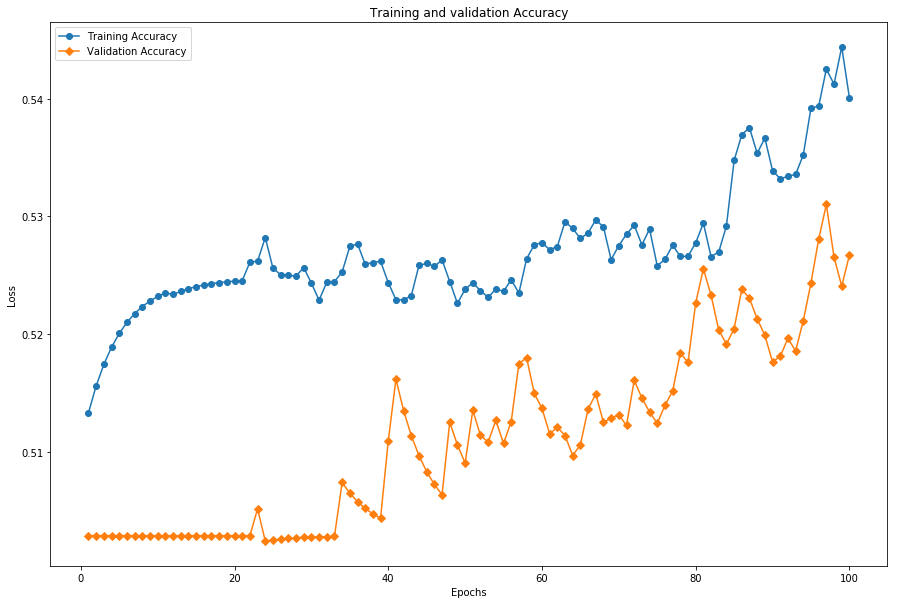

In [13]:
from helpers import smooth_curve

## Validation of model fitting
fig = plt.figure(figsize=(15, 10))
history_dict = classification_history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

# Smooth the curve and only show data after the 10th point
acc_values = smooth_curve(acc_values)
val_acc_values = smooth_curve(val_acc_values)

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'o-', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'D-', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig('document/figures/classification_epochs.pdf')

In [14]:
test_labels_pred = classifier.predict(X_test).reshape(-1) > 0.5
classification_accuracy = np.sum(test_labels_pred == test_labels) / len(test_labels)

baseline_test_labels = X_test.reshape([X_test.shape[0], X_test.shape[1] * X_test.shape[2]])[:,-2] > 0
baseline_classification_accuracy = np.sum(baseline_test_labels == test_labels) / len(test_labels)

print("Binary classification Accuracy Baseline: ", baseline_classification_accuracy)
print("Binary classification Accuracy: ", classification_accuracy)

Binary classification Accuracy Baseline:  0.480225988700565
Binary classification Accuracy:  0.4350282485875706


In [15]:
# import time
# print('Sunmmary:', time.asctime())
# print("Price forecasting MAE: ",regression_error)
# print("Binary classification Accuracy: ", classification_accuracy)